In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [3]:
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

In [4]:
# Define the directories that contain the files downloaded in 2017
# and 2018

dir_2015 = "/".join( ["E:"]+["Thatoi_Docs"] + ["Downloads"]+["LendingClubData2015"] )

# Define the output path for the pickle
pickle_file = "/".join(["E:"]+["Thatoi_Docs"]+["Downloads"]+["LendingClubData"] + ["clean_data.pickle"] )

In [5]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec', 'fico_range_high',
                 'fico_range_low', 'revol_bal','revol_util', 'total_pymnt',
                                                    'last_pymnt_d', 'recoveries','addr_state','zip_code']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']
geo_cols = ['addr_state','zip_code']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) -set(geo_cols)== set(["id"])

In [6]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

In [7]:
def ingest_files(directory):
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

In [8]:
files_2015 = ingest_files(dir_2015)

Directory E:/Thatoi_Docs/Downloads/LendingClubData2015/ has 1 files:
    Reading file LoanStats3d_securev1.csv
        Found 2 invalid rows which were removed


In [9]:
data_2015 = pd.concat(files_2015.values()).reset_index(drop = True)

data_2015=data_2015.sort_values(by='id')

# Ensure the loan IDs are a unique key
assert len(set(data_2015.id)) == len(data_2015)

# Keep only the columns of interest
final_data = data_2015[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Starting with 421095 rows


In [10]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )
    
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

In [11]:
# Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1093 rows


In [12]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )


final_data['return'] = ret_method_3(5*12, 0.0024) #3% 

In [12]:
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    ret_cols=['return']
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

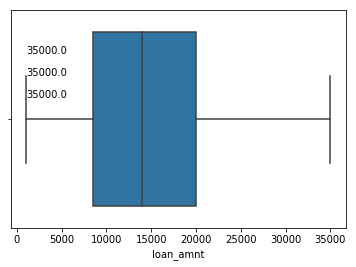

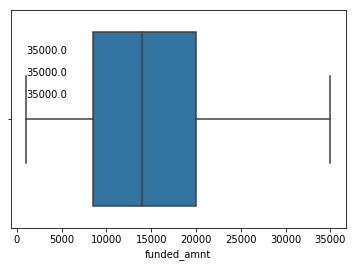

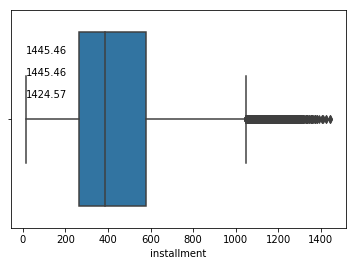

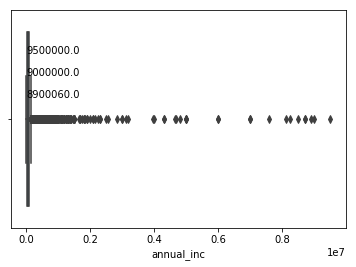

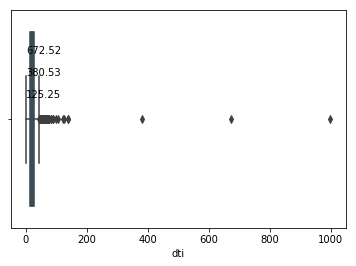

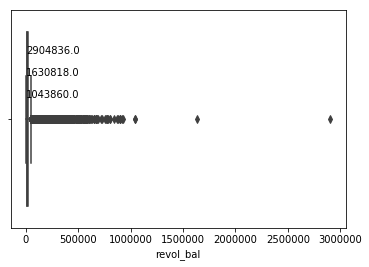

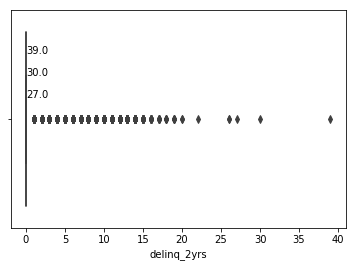

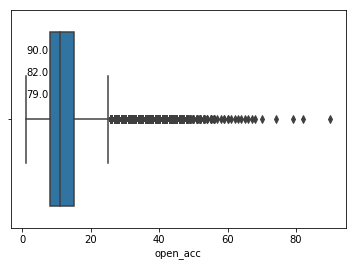

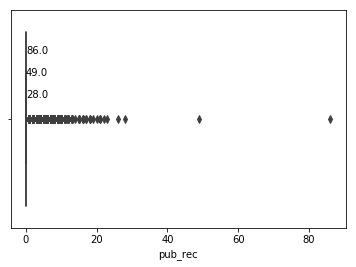

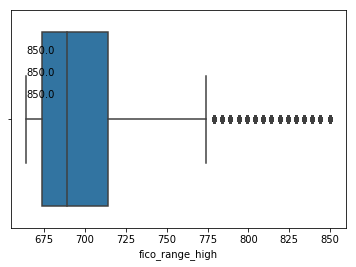

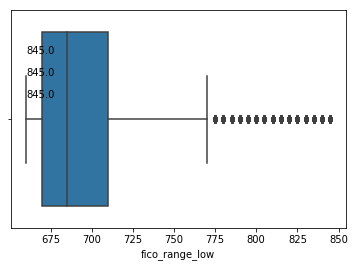

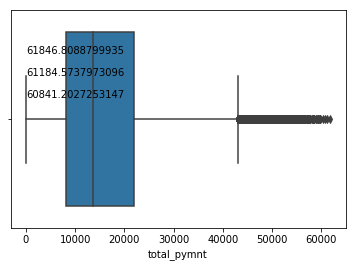

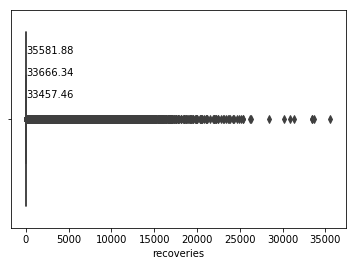

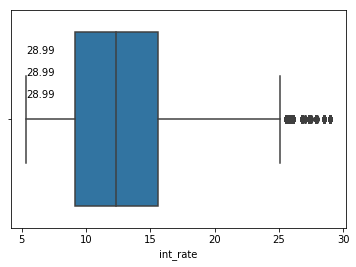

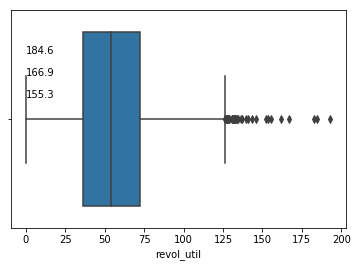

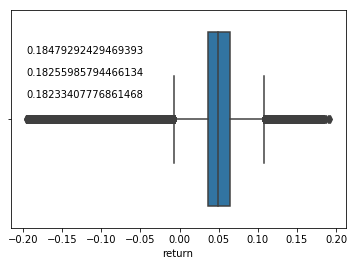

term
2 distinct values
 36 months    282477
 60 months    137525
Name: term, dtype: int64


grade
7 distinct values
C    120250
B    117346
A     73219
D     62458
E     34824
F      9761
G      2144
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    141174
2 years       37408
< 1 year      34246
3 years       33328
1 year        27407
5 years       24870
4 years       24447
8 years       21494
7 years       18366
6 years       16799
9 years       16716
Name: emp_length, dtype: int64


home_ownership
4 distinct values
MORTGAGE    207178
RENT        167217
OWN          45605
ANY              2
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Source Verified    184259
Verified           122695
Not Verified       113048
Name: verification_status, dtype: int64


loan_status
7 distinct values
Fully Paid            301328
Charged Off            76599
Current                40215
Late (31-120 days)      1144
In Grace Period          438
Late (16-3

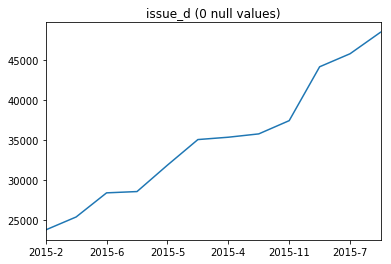

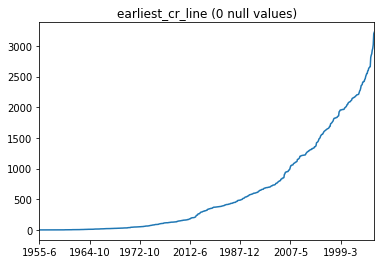

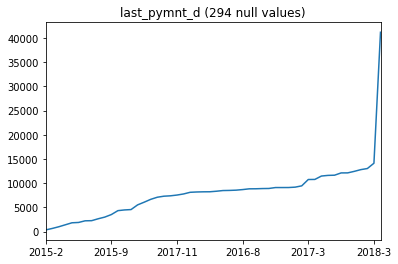

In [13]:
visualize_columns()

In [13]:
# There are quite a few outliers, but the two most obvious
# ones to remove are in annual_inc, revol_util Remove these.
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 9000000]
final_data = final_data[final_data.revol_util < 170]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 167 rows


In [14]:
# Remove all loans that are too recent to have been paid off or
# defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")
print("Remaining",final_data.shape[0]," rows")

Removed 42066 rows
Remaining 377769  rows


In [15]:
# Only include loans isssued since 2009
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2009, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


In [16]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 296 rows


In [17]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret = final_data.groupby("grade").apply(lambda x : np.mean(x['return']*100 ))
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))


combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return'] = ret

combined



,grade,default,int_rate,return
A,19.037653,5.543959,6.925644,3.857052
B,28.442299,13.041858,10.040383,3.933531
C,27.918288,22.444584,13.289780,3.576761
D,14.273869,32.201188,16.718765,2.952256
E,7.637367,41.756565,19.292331,1.911895
F,2.189031,50.950018,23.636809,0.907195
G,0.501493,54.463814,26.827110,0.347911


In [19]:
# OFFSET Calibration
final_data['return_lc']=np.nan
final_data['return_lc'][final_data['grade']=='A'] = final_data['return']/1.751087641
final_data['return_lc'][final_data['grade']=='B'] = final_data['return']/1.409933689
final_data['return_lc'][final_data['grade']=='C'] = final_data['return']/1.245417141
final_data['return_lc'][final_data['grade']=='D'] = final_data['return']/1.179172275
final_data['return_lc'][final_data['grade']=='E'] = final_data['return']/1.097812758
final_data['return_lc'][final_data['grade']=='F'] = final_data['return']/1.507483328
final_data['return_lc'][final_data['grade']=='G'] = final_data['return']/1.507483328

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [20]:
# Find the percentage of loans by grade, the default by grade --- After OFFSET
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret = final_data.groupby("grade").apply(lambda x : np.mean(x['return_lc']*100 ))
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))


combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return'] = ret

combined



,grade,default,int_rate,return
A,19.037653,5.543959,6.925644,2.202661
B,28.442299,13.041858,10.040383,2.789869
C,27.918288,22.444584,13.289780,2.871938
D,14.273869,32.201188,16.718765,2.503668
E,7.637367,41.756565,19.292331,1.741549
F,2.189031,50.950018,23.636809,0.601795
G,0.501493,54.463814,26.827110,0.230789


In [18]:
# Remove the total_pymnt from the list of continuous features; this
# variable is highly predictive of the outcome but is not known at
# the time the loan is issued
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]

### SOCIO-ECONOMIC DATA

In [19]:
os.chdir(r"E:\Thatoi_Docs\Individual_Project\source_files")
df_eco=pd.read_excel('clean_sc.xlsx')

In [20]:
list_eco=['Id2','Pop_wt','Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force',
'Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate',
'Estimate; COMMUTING TO WORK - Workers 16 years and over',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab)',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Walked',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Other means',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Worked at home',
'Estimate; COMMUTING TO WORK - Mean travel time to work (minutes)',
'Estimate; OCCUPATION - Civilian employed population 16 years and over',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Management, business, science, and arts occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Service occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Natural resources, construction, and maintenance occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Production, transportation, and material moving occupations',
'Estimate; INDUSTRY - Civilian employed population 16 years and over',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Agriculture, forestry, fishing and hunting, and mining',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Construction',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Manufacturing',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Wholesale trade',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Retail trade',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Transportation and warehousing, and utilities',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Information',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Finance and insurance, and real estate and rental and leasing',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Educational services, and health care and social assistance',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Arts, entertainment, and recreation, and accommodation and food services',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Other services, except public administration',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Public administration',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Private wage and salary workers',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Government workers',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Self-employed in own not incorporated business workers',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Unpaid family workers',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Less than $10,000',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $10,000 to $14,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $15,000 to $24,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $25,000 to $34,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $35,000 to $49,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $50,000 to $74,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $75,000 to $99,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $100,000 to $149,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $150,000 to $199,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $200,000 or more',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - Less than $10,000',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $10,000 to $14,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $15,000 to $24,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $25,000 to $34,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $35,000 to $49,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $50,000 to $74,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $75,000 to $99,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $100,000 to $149,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $150,000 to $199,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $200,000 or more',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - Median family income (dollars)',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - Mean family income (dollars)',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With private health insurance',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With public coverage',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - No health insurance coverage',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Married couple families',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Families with female householder, no husband present',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 18 to 64 years',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 65 years and over',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - People in families']
df_eco_sel = df_eco[list_eco]

In [21]:
len(list_eco)

72

In [22]:
def create_eco_file(df_t):
    df_t['zip_code']=df_t['Id2'].astype('int').apply(lambda x:format(x,'03d'))
    #Imputing missing values with median values
    for col in list_eco:
        df_t[col].fillna(df_t[col].median(),inplace=True)
    
    #Removing NA's if there are still any
    df_t=df_t.dropna(axis=0)
    
    print('Total unique zip codes are-->',df_t['zip_code'].nunique())
    
    # calculating population weighted values
    for col in list_eco:
        df_t[col]=df_t[col].astype('float')
        df_t[col]=df_t[col]*df_t['Pop_wt']
    
    #Creating the final aggregated dataset, grouped by first three digit zipcodes
    df_final=df_t.groupby('zip_code').sum().reset_index()
    
    return df_final

In [23]:
df_final = create_eco_file(df_eco_sel)

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\pandas\core\generic.py:6120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Total unique zip codes are--> 894


### CLEANING & MERGING

In [24]:
# Create the outcome
final_data["outcome"] = final_data.loan_status.isin(["Charged Off", "Default"])

In [25]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
final_data['cr_hist'] = (final_data.issue_d - final_data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [26]:
#Create New Dti
final_data['NMRA']=final_data['dti']*(final_data['annual_inc']/12)+ final_data['installment']
final_data['New_dti']=final_data['NMRA']/(final_data['annual_inc']/12)
final_data.drop('NMRA',axis=1,inplace=True)

In [27]:
#New revol_bal
cols=['revol_bal']
for col in cols:
    final_data[str(col)+"_wrt_loanamnt"]=final_data[col]/final_data['funded_amnt']

In [28]:
#Creating new state categorical variables in the dataframe
list_st=['CA','NY','TX','FL','IL','NJ','PA','GA','OH','VA']      

for st in list_st:
    final_data['state_'+st]=final_data['addr_state'].apply(lambda x: 1 if x == st else 0)

In [29]:
state_cols=['state_CA','state_NY','state_TX','state_FL','state_IL','state_NJ','state_PA','state_GA','state_OH','state_VA']
for st in state_cols:
    final_data[st]=final_data[st].astype('category',ordered=False)

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3267: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
#change in fico
final_data['change_in_fico'] = np.nan
final_data['change_in_fico']  = final_data['fico_range_high']/final_data['fico_range_low']

In [31]:
#making 3 digit zip_code
final_data['zip_code']=final_data['zip_code'].str.strip('x').astype('int').apply(lambda x:format(x,'03d'))


In [32]:
final_data = final_data.sort_values(by='zip_code')
df_final = df_final.sort_values(by='zip_code')
#final_data.to_csv('LendingClub_Target.csv',index=False)
#df_eco_sel.to_csv('Socio_economic.csv',index=False)

df_merge=pd.merge(final_data,df_final,on='zip_code',how = 'inner')

In [33]:
df_merge.shape

(377361, 117)

### PCA

In [34]:
del_columns = ['id','grade','installment','int_rate','issue_d','earliest_cr_line','emp_length', 
               'return', 'return_lc', 'outcome','term', 'home_ownership','verification_status',
              'loan_status', 'purpose', 'total_pymnt', 'last_pymnt_d', 'recoveries', 'addr_state', 'zip_code',
       'loan_length','state_CA', 'state_NY', 'state_TX',
       'state_FL', 'state_IL', 'state_NJ', 'state_PA', 'state_GA', 'state_OH',
       'state_VA']

required = set(cols_to_pick) - set(del_columns)

to_be_added = ['emp_length', 
               'return', 'outcome','term', 'home_ownership','verification_status',
              'purpose','state_CA', 'state_NY', 'state_TX',
       'state_FL', 'state_IL', 'state_NJ', 'state_PA', 'state_GA', 'state_OH',
       'state_VA']

del_col_eco = ['Id2','Pop_wt']
required_eco = set(list_eco) - set(del_col_eco)

final_list_pca=list(list(required)+list(required_eco))

pca_data = df_merge[final_list_pca]

In [35]:
#to be added to PCA
df_add = df_merge[to_be_added]

In [36]:
#scaling pca data
from sklearn.preprocessing import scale
pca_scale= scale(pca_data)

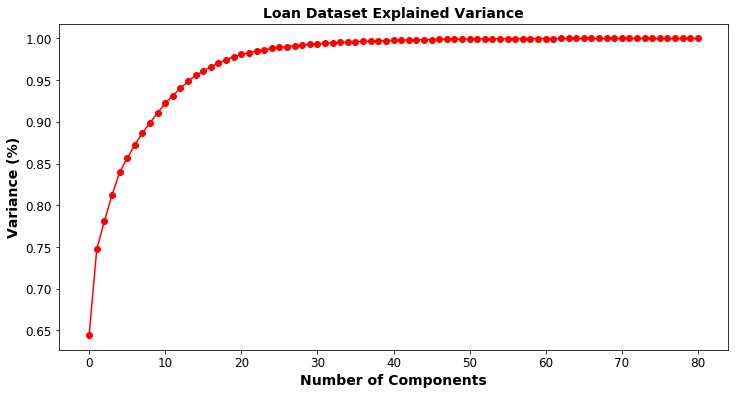

In [37]:
#visualizing PCA
from sklearn.decomposition import PCA
pca = PCA().fit(pca_scale)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize= (12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), ls="-",color='red',marker='o')
plt.xlabel('Number of Components',size=14,fontweight='bold')
plt.ylabel('Variance (%)',size = 14,fontweight='bold') #for each component
plt.title('Loan Dataset Explained Variance',size=14,fontweight='bold')
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

In [38]:
#selecting pca components with 90% variance
pca_1 = PCA(n_components = 10)
pca_dataset = pd.DataFrame(pca_1.fit_transform(pca_scale))

In [39]:
#merging with requuired columns
df_model = pd.merge(pca_dataset,df_add, left_index = True, right_index = True)

In [40]:
df_model.columns

Index([                    0,                     1,                     2,
                           3,                     4,                     5,
                           6,                     7,                     8,
                           9,          'emp_length',              'return',
                   'outcome',                'term',      'home_ownership',
       'verification_status',             'purpose',            'state_CA',
                  'state_NY',            'state_TX',            'state_FL',
                  'state_IL',            'state_NJ',            'state_PA',
                  'state_GA',            'state_OH',            'state_VA'],
      dtype='object')

### SAMPLING

In [41]:
# original dataset:
value=['home_improvement','major_purchase','medical','car','small_business','moving','vacation','house']
cat_cols=['term','emp_length','home_ownership','verification_status','purpose','state_CA', 'state_NY',
       'state_TX', 'state_FL', 'state_IL', 'state_NJ', 'state_PA', 'state_GA',
       'state_OH', 'state_VA']
category =['term','emp_length','home_ownership','verification_status','purpose']

def clean_df(df):

    df['verification_status'].iloc[np.where(df['verification_status']=='Source Verified')]='Verified'
    df['term'].iloc[np.where(df['term']==' 36 months')]='36months'
    df['term'].iloc[np.where(df['term']==' 60 months')]='60months'
    df['home_ownership'].iloc[np.where(df['home_ownership']=='ANY')]='MORTGAGE'
    for val in value:
        df['purpose'][df['purpose']== val]='other'
        
    dict={
    '< 1 year':1,
    '1 year': 2,
    '2 years':3,
    '3 years':4,
    '4 years':5,
    '5 years':6,
    '6 years':7,
    '7 years':8,
    '8 years':9,
    '9 years':10,
    '10+ years':11
    }
    df['emp_length']=df['emp_length'].map(dict)
    df['emp_length']=df['emp_length'].astype('category',ordered=True)
    
    #creating categories and floats
    for col in cat_cols:
        if col=='emp_length':
            df[col]=df[col].astype('category',ordered=True)
        else:
            df[col]=df[col].astype('category',ordered=False)

    #Dropping nulls
    df.dropna(axis=0,inplace=True)
    
    df_dum= pd.DataFrame(pd.get_dummies(df, columns=category, prefix_sep = "::", drop_first = True))
    return df_dum

df_model_2=clean_df(df_model)

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


In [42]:
df_model_2.sample(200000).to_csv('regression.csv',index=False)

In [49]:
df_model_2.columns

Index([                              0,                               1,
                                     2,                               3,
                                     4,                               5,
                                     6,                               7,
                                     8,                               9,
                              'return',                       'outcome',
                            'state_CA',                      'state_NY',
                            'state_TX',                      'state_FL',
                            'state_IL',                      'state_NJ',
                            'state_PA',                      'state_GA',
                            'state_OH',                      'state_VA',
                      'term::60months',               'emp_length::2.0',
                     'emp_length::3.0',               'emp_length::4.0',
                     'emp_length::5.0',            

In [46]:
Y = df_model_2['outcome']
X = df_model_2.drop(['outcome','return','return_lc'],axis=1)
Z = df_model_2[['return','return_lc']]

#### Random Under Sampling

In [47]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, Y_rus = rus.fit_resample(X,Y)
print('Resampled dataset shape %s' % Counter(Y_rus))

Resampled dataset shape Counter({False: 70702, True: 70702})


In [48]:
#creating RUS dataframe
X_rus = pd.DataFrame(X_rus)
Y_rus = pd.DataFrame(Y_rus).rename(columns={0:'outcome'})
RUS_sample_1 = pd.merge(X_rus,Y_rus, left_index= True, right_index=True)
#RUS_sample = pd.merge(RUS_sample_1,Z,left_index= True, right_index=True)


In [49]:
RUS_sample_1.shape

(141404, 40)

#### Random Over Sampling

In [50]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, Y_ros = ros.fit_resample(X,Y)
print('Resampled dataset shape %s' % Counter(Y_ros))

Resampled dataset shape Counter({True: 284576, False: 284576})


In [51]:
#creating RUS dataframe
X_ros = pd.DataFrame(X_ros)
Y_ros = pd.DataFrame(Y_ros).rename(columns={0:'outcome'})
ROS_sample_1 = pd.merge(X_ros,Y_ros, left_index= True, right_index=True)
#ROS_sample = pd.merge(ROS_sample_1,Z,left_index= True, right_index=True)
ROS_sample_1.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,outcome
0,-2.22477,-1.73717,1.68544,2.21328,3.04508,-0.179142,0.660474,0.0424036,-0.544269,-0.386674,...,0,0,1,1,0,0,0,0,0,True
1,-3.03159,0.433212,0.130574,0.327639,0.753624,0.636973,1.24849,0.604294,0.262102,-0.0947518,...,0,0,1,1,1,0,0,0,0,False
2,-3.03196,0.359166,2.66976,-1.29868,0.221496,-0.533318,-1.43208,2.33049,3.86898,0.000570241,...,0,0,0,1,0,0,0,0,0,False
3,-3.0281,0.397928,0.956711,-0.021735,-0.0550996,0.502466,0.55001,-0.434514,0.12857,-0.240585,...,1,0,0,1,1,0,0,0,0,True
4,-3.02907,0.46018,0.169179,0.255842,0.759899,-0.0426589,-0.286276,0.397394,-0.616653,-0.364359,...,0,1,0,1,0,0,0,0,0,False


In [52]:
ROS_sample_1['outcome'].value_counts()

True     284576
False    284576
Name: outcome, dtype: int64

#### SMOTE

In [53]:
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(categorical_features=[10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
                                      ,31,32,33,34,35,36,37,38])
X_sm, Y_sm = smote.fit_sample(X, Y)
print('Resampled dataset shape %s' % Counter(Y_sm))

Resampled dataset shape Counter({True: 284576, False: 284576})


In [54]:
#creating RUS dataframe
X_sm = pd.DataFrame(X_sm)
Y_sm = pd.DataFrame(Y_sm).rename(columns={0:'outcome'})
SMOTE_sample_1 = pd.merge(X_sm,Y_sm, left_index= True, right_index=True)
#SMOTE_sample = pd.merge(SMOTE_sample_1,Z, left_index=True,right_index=True)
SMOTE_sample_1.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,outcome
0,-2.22477,-1.73717,1.68544,2.21328,3.04508,-0.179142,0.660474,0.0424036,-0.544269,-0.386674,...,0,0,1,1,0,0,0,0,0,True
1,-3.03159,0.433212,0.130574,0.327639,0.753624,0.636973,1.24849,0.604294,0.262102,-0.0947518,...,0,0,1,1,1,0,0,0,0,False
2,-3.03196,0.359166,2.66976,-1.29868,0.221496,-0.533318,-1.43208,2.33049,3.86898,0.000570241,...,0,0,0,1,0,0,0,0,0,False
3,-3.0281,0.397928,0.956711,-0.021735,-0.0550996,0.502466,0.55001,-0.434514,0.12857,-0.240585,...,1,0,0,1,1,0,0,0,0,True
4,-3.02907,0.46018,0.169179,0.255842,0.759899,-0.0426589,-0.286276,0.397394,-0.616653,-0.364359,...,0,1,0,1,0,0,0,0,0,False


In [55]:
SMOTE_sample_1['outcome'].value_counts()

True     284576
False    284576
Name: outcome, dtype: int64

In [56]:
print(SMOTE_sample_1.shape)
print(RUS_sample_1.shape)
print(ROS_sample_1.shape)

(569152, 40)
(141404, 40)
(569152, 40)


#### ADASYN

In [57]:
from imblearn.over_sampling import ADASYN 
smote = ADASYN (ratio='minority')
X_ada, Y_ada = smote.fit_sample(X, Y)
print('Resampled dataset shape %s' % Counter(Y_ada))

Resampled dataset shape Counter({False: 284576, True: 273427})


In [58]:
#creating RUS dataframe
X_ada = pd.DataFrame(X_ada)
Y_ada = pd.DataFrame(Y_ada).rename(columns={0:'outcome'})
ADA_sample_1 = pd.merge(X_ada,Y_ada, left_index= True, right_index=True)
ADA_sample = pd.merge(SMOTE_sample_1,Z, left_index=True,right_index=True)
ADA_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,outcome,return,return_lc
0,-2.22477,-1.73717,1.68544,2.21328,3.04508,-0.179142,0.660474,0.0424036,-0.544269,-0.386674,...,1,1,0,0,0,0,0,True,-0.042214,-0.033896
1,-3.03159,0.433212,0.130574,0.327639,0.753624,0.636973,1.24849,0.604294,0.262102,-0.0947518,...,1,1,1,0,0,0,0,False,0.037055,0.031424
2,-3.03196,0.359166,2.66976,-1.29868,0.221496,-0.533318,-1.43208,2.33049,3.86898,0.000570241,...,0,1,0,0,0,0,0,False,0.063240,0.044853
3,-3.0281,0.397928,0.956711,-0.021735,-0.0550996,0.502466,0.55001,-0.434514,0.12857,-0.240585,...,0,1,1,0,0,0,0,True,-0.031473,-0.028669
4,-3.02907,0.46018,0.169179,0.255842,0.759899,-0.0426589,-0.286276,0.397394,-0.616653,-0.364359,...,0,1,0,0,0,0,0,False,0.073479,0.052115


#### Writing Sample dataset

In [59]:
os.chdir(r"D:/")
#RUS_sample_1.to_csv('RUS_Sample.csv',index=False)
#ROS_sample_1.to_csv('ROS_Sample.csv',index=False)
#SMOTE_sample_1.to_csv('SMOTE_Sample.csv',index=False)
#ADA_sample.to_csv('ADASYN_Sample.csv',index=False)
#ret_cols=['return']
#pickle.dump( [df_eco_sel,final_data, discrete_features, continuous_features, ret_cols,geo_cols,list_eco], open(pickle_file, "wb") )